In [1]:
import pandas as pd
from math import log2
import random

In [2]:
positive_value='recurrence-events'
negative_value='no-recurrence-events'
unknown_value='?'

In [3]:
class Node:
    def __init__(self):
        self.decision_attribute= ' ' 
        self.test_branch={}
        self.leaf_label='non-leaf node'

In [4]:
def print_tree(root, key_value_string, target_attribute):
    if root.leaf_label != 'non-leaf node':
        if root.leaf_label:
            print(key_value_string + '\b\b\b\b' + ' → ' + '[' + target_attribute + ' = ' + positive_value + ']')
        else:
            print(key_value_string + '\b\b\b\b' + ' → ' + '[' + target_attribute + ' = ' + negative_value + ']')
    if root.leaf_label == 'non-leaf node':
        for v in root.test_branch.keys():
            tmp = key_value_string + '[' + root.decision_attribute + ' = ' + str(v) + '] ' + ' ∧ '
            print_tree(root.test_branch[v], tmp, target_attribute)
    return

Calculate Entropy:

This is one the most important decision methods in building a decision trees. As there are many attributes, how to choose the right one to classify. Here the ID3 borrows the entropy methods from the information theory which indicates the more uncertain of the results, the larger the entropy is. 

For the binary decision, the entropy work like this:

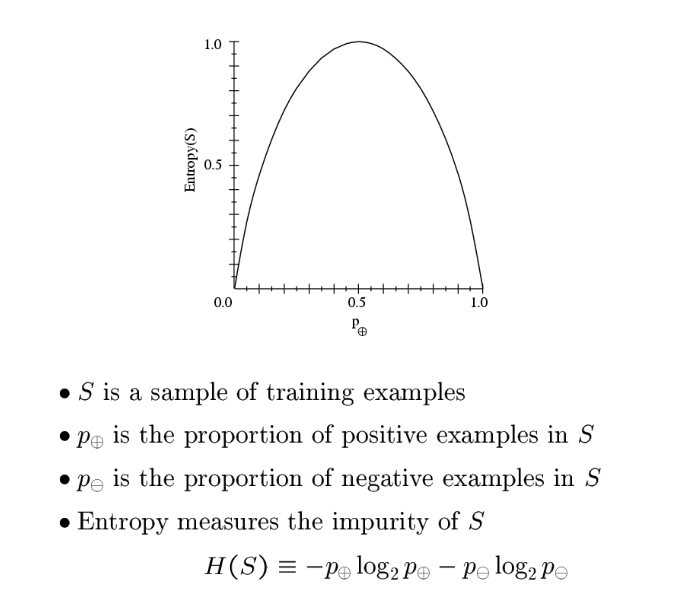

In [5]:
def entropy(s, target_attribute):
    if s.empty:
        return 0
    ent=0
    s_size=len(s)
    classes=s[target_attribute].unique()
    for i in classes:
        pi=(s[target_attribute]==i).sum()/s_size
        if pi!= 0:
            ent += -pi*log2(pi)
    return ent

Calculate Infomration Gain:

Information Gain is the expected reduction in entropy of target variable Y for data sample S, due to sorting on variable A.

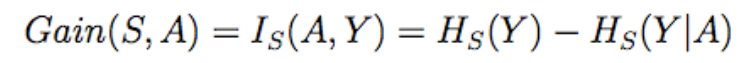

In [6]:
def information_gain(s, target_attribute, attribute):
    s_size=len(s)
    entropy_s=entropy(s, target_attribute)
    values=s[attribute].unique()
    weighted_entropy_summary=0
    for v in values:
        s_v=s[s[attribute]==v] #why s[s[]]?
        s_size_v=len(s_v)
        entropy_s_v=entropy(s_v, target_attribute)
        weighted_entropy_summary+=s_size_v*entropy_s_v/s_size
    return entropy_s-weighted_entropy_summary

Building Trees

In [7]:
def id3_build_tree(examples,target_attribute,attributes):
    root=Node()
    if(examples[target_attribute]==positive_value).all():
        root.leaf_label=True
        return root
    if (examples[target_attribute]==negative_value).all():
        root.leaf_label=False
        return root
    if not attributes: #why if not 
        root.leaf_label=examples[target_attribute].mode()[0]==positive_value #why mode?
        return root
    ig=[]
    for attribute in attributes:
        ig.append(information_gain(examples, target_attribute,attribute))
    a=attributes[ig.index(max(ig))]
    
    root.decision_attribute=a
    values=examples[a].unique()
    for vi in values:
        examples_vi=examples[examples[a]==vi]
        if examples.empty:
            new_node=Node()
            new_node.leaf_label=examples[target_attribute].mode()[0]==positive_value
        else:
            new_node=id3_build_tree(examples_vi, target_attribute,[i for i in attributes if i!=a])
        if vi!=unknown_value:
            root.test_branch.update({vi:new_node})
            
    return root

In [8]:
def id3_prune(examples,target_attribute,root,tree):
    if root.leaf_label != 'non-leaf node':
        return root
    for v in root.test_branch.keys():
        root.test_branch[v]=id3_prune(examples,target_attribute,root.test_branch[v],tree)
    old_correctness=id3_correctness(tree,examples,target_attribute)
    root.leaf_label=examples[target_attribute].mode()[0]==positive_value
    new_correctness=id3_correctness(tree,examples,target_attribute)
    if new_correctness>old_correctness:
        return root
    else:
        root.leaf_label='non-leaf node'
        return root

In [9]:
def id3_classify(root,example):
    while root.leaf_label=='non-leaf node':
        if example[root.decision_attribute] in root.test_branch:
            root=root.test_branch[example[root.decision_attribute]]
        elif example[root.decision_attribute]==unknown_value:
            root=root.test_branch[random.choice(list(root.test_branch))]
        else:
            return 'decline to classify'
    if root.leaf_label:
        return positive_value
    else:
        return negative_value

In [10]:
def id3_correctness(root,example_test,target_attribute):
    test_size=len(example_test)
    correct=0
    for i in range(test_size):
        real_result=example_test.loc[i,target_attribute]
        id3_result=id3_classify(root,example_test.loc[i,:])
        if real_result==id3_result:
            correct += 1
    return correct/test_size

In [11]:
def divide_train_test(cancer,fraction,fraction_train):
    threshold=int(fraction*len(cancer))
    threshold_train=int(fraction_train*threshold)
    train1=cancer.loc[0:threshold_train,:]
    train1=train1.reset_index(drop=True)
    train2=cancer.loc[threshold_train:threshold,:]
    train2=train2.reset_index(drop=True)
    test=cancer.loc[threshold:len(cancer),:]
    test=test.reset_index(drop=True)
    return train1,train2,test

In [12]:
def save_tree(tree,filename):
    import pickle
    fw=open(filename,'wb')
    pickle.dump(tree,fw)
    fw.close()

In [13]:
def load_tree(filename):
    import pickle
    fr=open(filename,'rb')
    tree=pickle.load(fr)
    fr.close()
    return tree

In [14]:
target_attribute = 'Class' 
attributes = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps',
          'deg-malig', 'breast', 'breast-quad', 'irradiat'] 
breast_cancer = pd.read_csv('breast-cancer.data', names=attributes).sample(frac=1)
breast_cancer = breast_cancer.reset_index(drop=True)
breast_cancer_train1, breast_cancer_train2, breast_cancer_test = divide_train_test(breast_cancer, 1, 0.6)
attributes.remove(target_attribute)   
id3_tree = id3_build_tree(breast_cancer_train1, target_attribute, attributes)
id3_tree = id3_prune(breast_cancer_train2, target_attribute, id3_tree, id3_tree)
print_tree(id3_tree, '', target_attribute) 
save_tree(id3_tree, 'id3_tree.tree')
print('train1: ', len(breast_cancer_train1), 'train2: ', len(breast_cancer_train2), 'test: ', len(breast_cancer_test))
print('precision', id3_correctness(id3_tree, breast_cancer_train2, target_attribute))

[tumor-size = 30-34]  ∧ [inv-nodes = 0-2]  ∧  → [Class = no-recurrence-events]
[tumor-size = 30-34]  ∧ [inv-nodes = 6-8]  ∧  → [Class = no-recurrence-events]
[tumor-size = 30-34]  ∧ [inv-nodes = 3-5]  ∧ [node-caps = no]  ∧  → [Class = recurrence-events]
[tumor-size = 30-34]  ∧ [inv-nodes = 3-5]  ∧ [node-caps = yes]  ∧  → [Class = no-recurrence-events]
[tumor-size = 30-34]  ∧ [inv-nodes = 15-17]  ∧  → [Class = recurrence-events]
[tumor-size = 30-34]  ∧ [inv-nodes = 9-11]  ∧ [node-caps = yes]  ∧  → [Class = recurrence-events]
[tumor-size = 30-34]  ∧ [inv-nodes = 9-11]  ∧ [node-caps = no]  ∧  → [Class = recurrence-events]
[tumor-size = 25-29]  ∧ [deg-malig = 1]  ∧  → [Class = no-recurrence-events]
[tumor-size = 25-29]  ∧ [deg-malig = 2]  ∧ [breast-quad = left_up]  ∧  → [Class = no-recurrence-events]
[tumor-size = 25-29]  ∧ [deg-malig = 2]  ∧ [breast-quad = left_low]  ∧  → [Class = no-recurrence-events]
[tumor-size = 25-29]  ∧ [deg-malig = 2]  ∧ [bre